# OPEN FOOD NOTEBOOK

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
#import folium
import re
%matplotlib inline

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import seaborn as sns

#from google.cloud import translate
#import pycountry
import emoji

#translate_client = translate.Client()

We need to create a data folder where the .csv file will be stored and also a maps folder where .html maps will be stored

In [2]:
data_folder = './data/'
maps_folder = './maps/'

In [3]:
filename = 'en.openfoodfacts.org.products.csv'

In [4]:
using_col = [
    "product_name",
    "generic_name",
    "quantity",
    "brands",
    "brands_tags",
    "categories",
    "categories_tags",
    "categories_en",
    "origins",
    "origins_tags",
    "manufacturing_places",
    "manufacturing_places_tags",
    "labels",
    "labels_tags",
    "labels_en",
    "purchase_places",
    "countries",
    "countries_tags",
    "countries_en",
    "ingredients_text",
    "allergens",
    "allergens_en",
    "traces",
    "traces_tags",
    "traces_en",
    "nutrition_grade_uk",
    "nutrition_grade_fr",
    "main_category",
    "main_category_en",
    "energy_100g",
    "energy-from-fat_100g",
    "fat_100g",
    "saturated-fat_100g",
    "trans-fat_100g",
    "cholesterol_100g",
    "carbohydrates_100g",
    "sugars_100g",
    "fiber_100g",
    "proteins_100g",
    "salt_100g",
    "sodium_100g",
    "alcohol_100g",
    "calcium_100g",
    "iron_100g",
    "carbon-footprint_100g",
    "nutrition-score-fr_100g",
    "nutrition-score-uk_100g",
    "glycemic-index_100g"
]

In [5]:
food_df = pd.read_csv(data_folder + filename, 
                      sep='\t',
                      header=0,
                      usecols = using_col,
                      quotechar='"', 
                      low_memory=False)

In [6]:
print("The types of the data set are: \n", format(food_df.dtypes))
print ("The total size of the data set is:", format(food_df.shape) )

The types of the data set are: 
 product_name                  object
generic_name                  object
quantity                      object
brands                        object
brands_tags                   object
categories                    object
categories_tags               object
categories_en                 object
origins                       object
origins_tags                  object
manufacturing_places          object
manufacturing_places_tags     object
labels                        object
labels_tags                   object
labels_en                     object
purchase_places               object
countries                     object
countries_tags                object
countries_en                  object
ingredients_text              object
allergens                     object
allergens_en                  object
traces                        object
traces_tags                   object
traces_en                     object
nutrition_grade_uk           float64
nutri

## Cleaning float64 columns

In this section we have cleaning the values of the following columns: 
+ cholesterol\_100g
+ fat\_100g
+ proteins\_100g
+ fiber\_100g
+ carbohydrates\_100g
+ sugars\_100g
+ salt\_100g
+ sodium\_100g
+ alcohol\_100g
+ calcium\_100g
+ iron\_100g
+ satured-fat\_100g
+ trans-fat\_100g

Each column contains the quantity in grams of the feature of its name that a product has in 100 grams. We realised that the majority of these columns has values higher than 100 grams or negative values that does not make sense.

For example, in the columns such as cholesterol\_100g we searched that the quantity of cholesterol is related with the fat quantity in the foods, [https://www.ucsfhealth.org/education/cholesterol_content_of_foods/]. The cholesterol quantity never is higher than the quantity of fat and usually is described in milligrams. In the different examples shown in that link we realised in the worst case the highest value of cholesterol is always lower than 1g. The same occurs to the other colums such as salt\_100g or sodium\_100g. 

For cleaning the outliers we have used different functions: 

+ negative\_values (indexes, df, column\_name): converts the negative values of the column parameter to positive ones.
+ high\_values (indexes, df, column\_name, denom): converts the values higher than 100, that means the units that represents the quantity of the values are wrong (i.e milligrams instead of grams)

Also, we have used other two auxiliar functions:

+ non_null_num (df, column_name): helps us to see the percentage of non null values we have in our data base.
+ plot_bloxplot (df, column_name): helps us to see the bloxpot of each column cleaned. 

In [7]:
def non_null_num (df, column_name):
    notnull_n = df[df[column_name].notnull()].shape[0]
    print("Total number of not null elements:" , format(notnull_n))
    print("Percentage of the total:" , float("{0:.2f}".format(notnull_n*100/df.shape[0])))

def high_values (indexes, df, column_name, denom):
    for idx in indexes:
        old_val = df.loc[idx, column_name]
        new_val = old_val/denom
        df.loc[idx, column_name] = new_val
        
def negative_values(indexes, df, column_name):
    for idx in indexes:
        old_val = df.loc[idx, column_name]
        new_val = old_val * (-1)
        df.loc[idx, column_name] = new_val

def plot_boxplot (df, column_name):
    sns.boxplot(x=df[column_name]).set_title(column_name)

### cholesterol\_100g

In [8]:
non_null_num (food_df, 'cholesterol_100g')
food_df[food_df['cholesterol_100g'].notnull()][['cholesterol_100g']].describe()

Total number of not null elements: 144622
Percentage of the total: 20.84


,cholesterol_100g
count,144622.000000
mean,0.023916
std,0.635239
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,127.000000


In [9]:
indexes_chol = food_df.loc[food_df['cholesterol_100g'] > 1].index
high_values(indexes_chol, food_df, 'cholesterol_100g',1000)
food_df.cholesterol_100g.describe()

count    144622.000000
mean          0.018320
std           0.038236
min           0.000000
25%           0.000000
50%           0.000000
75%           0.020000
max           1.000000
Name: cholesterol_100g, dtype: float64

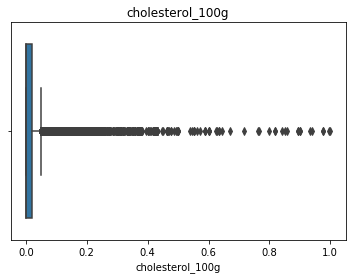

In [10]:
plot_boxplot(food_df,'cholesterol_100g')

### fat\_100g

In [11]:
non_null_num(food_df,'fat_100g')
food_df[food_df['fat_100g'].notnull()][['fat_100g']].describe()

Total number of not null elements: 586719
Percentage of the total: 84.54


,fat_100g
count,586719.000000
mean,13.636445
std,112.227224
min,0.000000
25%,0.500000
50%,6.300000
75%,21.000000
max,66700.000000


In [12]:
indexes_fat = food_df.loc[food_df['fat_100g'] > 100].index
high_values(indexes_fat, food_df, 'fat_100g',1000)
food_df.fat_100g.describe()

count    586719.000000
mean         13.245639
std          17.412664
min           0.000000
25%           0.500000
50%           6.300000
75%          21.000000
max         100.000000
Name: fat_100g, dtype: float64

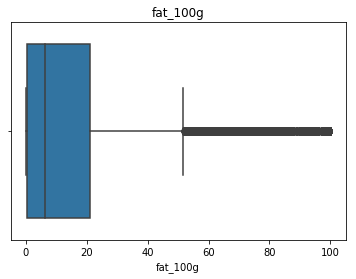

In [13]:
plot_boxplot(food_df,'fat_100g')

### proteins\_100g

In [14]:
non_null_num(food_df,'proteins_100g')
food_df[food_df['proteins_100g'].notnull()][['proteins_100g']].describe()

Total number of not null elements: 590697
Percentage of the total: 85.12


,proteins_100g
count,590697.000000
mean,8.187226
std,64.227382
min,-800.000000
25%,1.000000
50%,5.400000
75%,11.000000
max,31000.000000


The products whose protein value is negative we multiplied that value times -1 and then divided by 1000. 

In [15]:
indexes_neg = food_df.loc[(food_df['proteins_100g'] < 0 )].index
negative_values(indexes_neg, food_df, 'proteins_100g') 
indexes_high = food_df.loc[(food_df['proteins_100g'] > 100 )].index
high_values(indexes_high, food_df, 'proteins_100g',1000)
food_df.proteins_100g.describe()

count    590697.000000
mean          7.891068
std           9.218502
min           0.000000
25%           1.000000
50%           5.400000
75%          11.000000
max         100.000000
Name: proteins_100g, dtype: float64

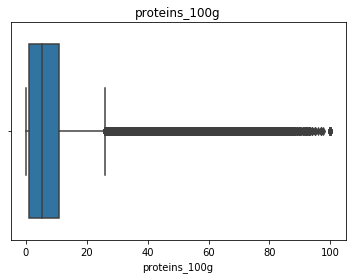

In [16]:
plot_boxplot(food_df,'proteins_100g')

### fiber\_100g

In [17]:
non_null_num(food_df,'fiber_100g')
food_df[food_df['fiber_100g'].notnull()][['fiber_100g']].describe()

Total number of not null elements: 273627
Percentage of the total: 39.43


,fiber_100g
count,2.736270e+05
mean,2.036346e+04
std,1.064819e+07
min,-2.000000e+01
25%,0.000000e+00
50%,1.500000e+00
75%,3.600000e+00
max,5.570000e+09


In [18]:
indexes_neg = food_df.loc[(food_df['fiber_100g'] < 0 )].index
negative_values(indexes_neg, food_df, 'fiber_100g') 
indexes_high = food_df.loc[(food_df['fiber_100g'] > 100 )].index
high_values(indexes_high, food_df, 'fiber_100g',100000000)
food_df.fiber_100g.describe()

count    273627.000000
mean          2.931741
std           4.985133
min           0.000000
25%           0.000000
50%           1.500000
75%           3.600000
max         100.000000
Name: fiber_100g, dtype: float64

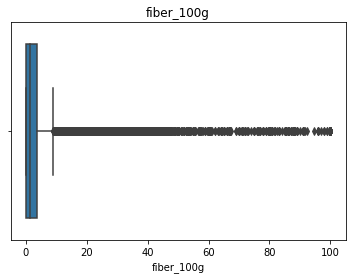

In [19]:
plot_boxplot(food_df,'fiber_100g')

### carbohydrates\_100g

In [20]:
non_null_num(food_df,'carbohydrates_100g')
food_df[food_df['carbohydrates_100g'].notnull()][['carbohydrates_100g']].describe()

Total number of not null elements: 586457
Percentage of the total: 84.51


,carbohydrates_100g
count,586457.000000
mean,30.989883
std,273.626685
min,0.000000
25%,3.900000
50%,16.670000
75%,55.000000
max,86700.000000


In [21]:
indexes_high = food_df.loc[(food_df['carbohydrates_100g'] > 100 )].index
high_values(indexes_high, food_df, 'carbohydrates_100g',1000)
food_df.carbohydrates_100g.describe()

count    586457.000000
mean         29.321101
std          28.557781
min           0.000000
25%           3.900000
50%          16.670000
75%          55.000000
max         100.000000
Name: carbohydrates_100g, dtype: float64

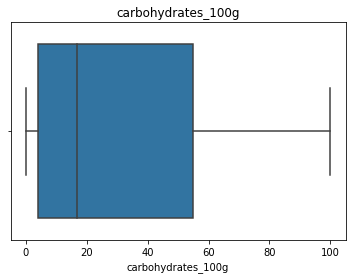

In [22]:
plot_boxplot(food_df,'carbohydrates_100g')

### sugars\_100g

In [23]:
non_null_num(food_df,'sugars_100g')
food_df[food_df['sugars_100g'].notnull()][['sugars_100g']].describe()

Total number of not null elements: 576107
Percentage of the total: 83.01


,sugars_100g
count,576107.000000
mean,15.775378
std,194.921331
min,-17.860000
25%,0.810000
50%,4.400000
75%,21.820000
max,86700.000000


In [24]:
indexes_neg = food_df.loc[(food_df['sugars_100g'] < 0 )].index
negative_values(indexes_neg, food_df, 'sugars_100g') 
indexes_high = food_df.loc[(food_df['sugars_100g'] > 100 )].index
high_values(indexes_high, food_df, 'sugars_100g',1000)
food_df.sugars_100g.describe()

count    576107.000000
mean         14.762345
std          20.656944
min           0.000000
25%           0.810000
50%           4.400000
75%          21.800000
max         100.000000
Name: sugars_100g, dtype: float64

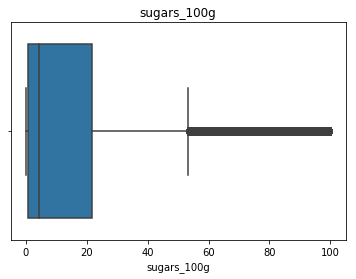

In [25]:
plot_boxplot(food_df,'sugars_100g')

### salt\_100g

In [26]:
non_null_num(food_df,'salt_100g')
food_df[food_df['salt_100g'].notnull()][['salt_100g']].describe()

Total number of not null elements: 570941
Percentage of the total: 82.27


,salt_100g
count,570941.000000
mean,3.282637
std,511.943315
min,0.000000
25%,0.065000
50%,0.543560
75%,1.353820
max,348000.000000


In [35]:
indexes_high = food_df.loc[(food_df['salt_100g'] >100 )].index
high_values(indexes_high, food_df, 'salt_100g',1000)
indexes_high = food_df.loc[(food_df['salt_100g'] >100 )].index
high_values(indexes_high, food_df, 'salt_100g',10)
food_df.salt_100g.describe()

count    570941.000000
mean          1.479599
std           5.823082
min           0.000000
25%           0.065000
50%           0.541020
75%           1.350000
max         100.000000
Name: salt_100g, dtype: float64

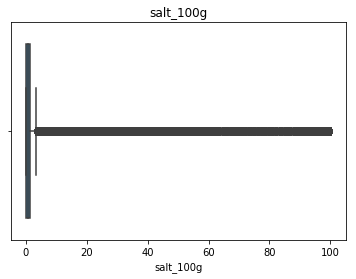

In [36]:
plot_boxplot(food_df,'salt_100g')

### sodium\_100g

In [37]:
non_null_num(food_df,'sodium_100g')
food_df[food_df['sodium_100g'].notnull()][['sodium_100g']].describe()

Total number of not null elements: 570905
Percentage of the total: 82.26


,sodium_100g
count,570905.000000
mean,1.292445
std,201.539672
min,0.000000
25%,0.025984
50%,0.214000
75%,0.533000
max,137000.000000


In [38]:
indexes_high = food_df.loc[(food_df['sodium_100g'] > 100 )].index
high_values(indexes_high, food_df, 'sodium_100g',1000)
indexes_high = food_df.loc[(food_df['sodium_100g'] > 100 )].index
high_values(indexes_high, food_df, 'sodium_100g',10)
food_df.sodium_100g.describe()

count    570905.000000
mean          0.598853
std           2.483878
min           0.000000
25%           0.025984
50%           0.214000
75%           0.533000
max         100.000000
Name: sodium_100g, dtype: float64

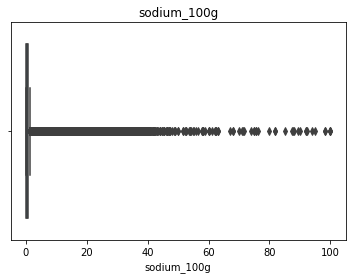

In [39]:
plot_boxplot(food_df,'sodium_100g')

### alcohol\_100g

In [40]:
non_null_num(food_df,'alcohol_100g')
food_df[food_df['alcohol_100g'].notnull()][['alcohol_100g']].describe()

Total number of not null elements: 7900
Percentage of the total: 1.14


,alcohol_100g
count,7900.000000
mean,7.049163
std,10.381637
min,0.000000
25%,0.000000
50%,4.500000
75%,12.000000
max,100.000000


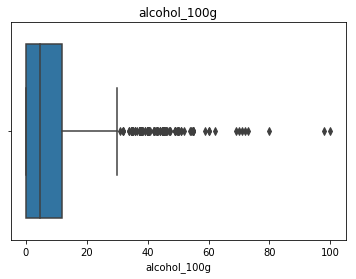

In [41]:
plot_boxplot(food_df,'alcohol_100g')

### calcium_100g

In [42]:
non_null_num(food_df,'calcium_100g')
food_df[food_df['calcium_100g'].notnull()][['calcium_100g']].describe()

Total number of not null elements: 143447
Percentage of the total: 20.67


,calcium_100g
count,143447.000000
mean,0.186045
std,5.408484
min,0.000000
25%,0.000000
50%,0.036000
75%,0.111000
max,779.000000


In [43]:
indexes_high = food_df.loc[(food_df['calcium_100g'] > 100 )].index
high_values(indexes_high, food_df, 'calcium_100g',1000)
food_df.calcium_100g.describe()

count    143447.000000
mean          0.110466
std           0.884419
min           0.000000
25%           0.000000
50%           0.036000
75%           0.111000
max         100.000000
Name: calcium_100g, dtype: float64

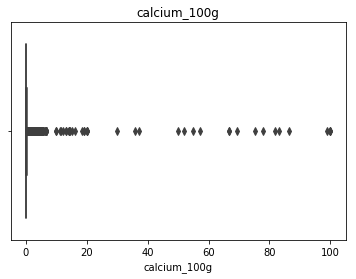

In [44]:
plot_boxplot(food_df,'calcium_100g')

### iron_100g

In [45]:
non_null_num(food_df,'iron_100g')
food_df[food_df['iron_100g'].notnull()][['iron_100g']].describe()

Total number of not null elements: 141583
Percentage of the total: 20.4


,iron_100g
count,141583.000000
mean,0.006226
std,0.387411
min,-0.000260
25%,0.000000
50%,0.001030
75%,0.002410
max,96.000000


In [46]:
indexes_neg = food_df.loc[(food_df['iron_100g'] < 0 )].index
negative_values(indexes_neg, food_df, 'iron_100g') 
food_df.iron_100g.describe()

count    141583.000000
mean          0.006226
std           0.387411
min           0.000000
25%           0.000000
50%           0.001030
75%           0.002410
max          96.000000
Name: iron_100g, dtype: float64

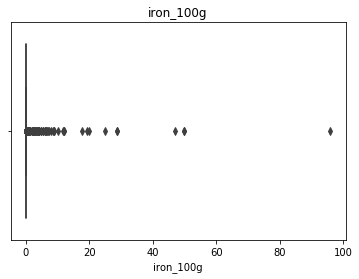

In [47]:
plot_boxplot(food_df,'iron_100g')

### satured-fat_100g

In [48]:
non_null_num(food_df,'saturated-fat_100g')
food_df[food_df['saturated-fat_100g'].notnull()][['saturated-fat_100g']].describe()

Total number of not null elements: 560845
Percentage of the total: 80.82


,saturated-fat_100g
count,560845.000000
mean,5.350258
std,42.536200
min,0.000000
25%,0.100000
50%,1.800000
75%,7.300000
max,18000.000000


In [49]:
indexes_high = food_df.loc[(food_df['saturated-fat_100g'] > 100 )].index
high_values(indexes_high, food_df, 'saturated-fat_100g',1000)
food_df['saturated-fat_100g'].describe()

count    560845.000000
mean          5.156019
std           7.872297
min           0.000000
25%           0.100000
50%           1.800000
75%           7.300000
max         100.000000
Name: saturated-fat_100g, dtype: float64

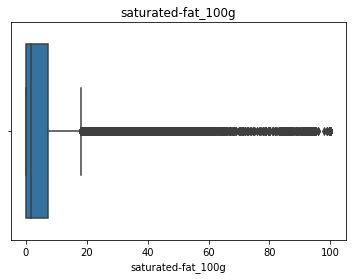

In [50]:
plot_boxplot(food_df,'saturated-fat_100g')

### trans-fat_100g

In [51]:
non_null_num(food_df,'trans-fat_100g')
food_df[food_df['trans-fat_100g'].notnull()][['trans-fat_100g']].describe()

Total number of not null elements: 143945
Percentage of the total: 20.74


,trans-fat_100g
count,143945.000000
mean,0.074167
std,1.544740
min,-3.570000
25%,0.000000
50%,0.000000
75%,0.000000
max,369.000000


In [53]:
indexes_neg = food_df.loc[(food_df['trans-fat_100g'] < 0 )].index
negative_values(indexes_neg, food_df, 'trans-fat_100g') 
indexes_high = food_df.loc[(food_df['trans-fat_100g'] > 100 )].index
high_values(indexes_high, food_df, 'trans-fat_100g',1000)
food_df['trans-fat_100g'].describe()

count    143945.000000
mean          0.067951
std           0.955906
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         100.000000
Name: trans-fat_100g, dtype: float64

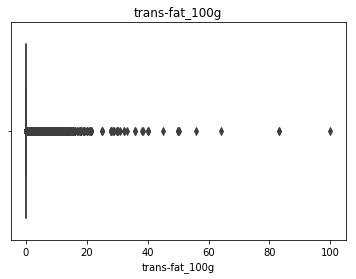

In [54]:
plot_boxplot(food_df,'trans-fat_100g')

### energy_100g

In [89]:
non_null_num(food_df,'energy_100g')
food_df[food_df['energy_100g'].notnull()][['energy_100g']].describe()

Total number of not null elements: 592128
Percentage of the total: 85.32


,energy_100g
count,5.921280e+05
mean,1.176823e+03
std,7.925630e+03
min,0.000000e+00
25%,4.180000e+02
50%,1.096000e+03
75%,1.674000e+03
max,2.845810e+06


In [ ]:
indexes_high = food_df.loc[(food_df['energy_100g'] > 100 )].index
high_values(indexes_high, food_df, 'energy_100g',10000)
food_df['trans-fat_100g'].describe()

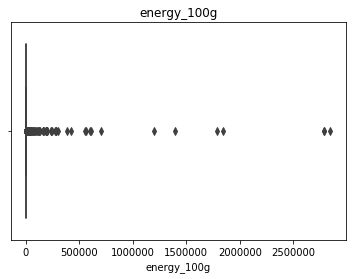

In [12]:
plot_boxplot(food_df,'energy_100g')